# Multimodal Retrieval using LlamaIndex


### Overview:
This code implements one of the multiple ways of multi-model RAG. It extracts and processes text and images from PDFs, utilizing a multi-modal Retrieval-Augmented Generation (RAG) system for summarizing and retrieving content for question answering.

### Key Components:
   - **PyMuPDF**: For extracting text and images from PDFs.
   - **Gemini 1.5-flash model**: To summarize images and tables.
   - **Cohere Embeddings**: For embedding document splits.
   - **LlamaIndex VectorStoreIndex**: To store and retrieve embedded document chunks efficiently.
   - **LlamaIndex Framework**: To orchestrate the end-to-end retrieval, embedding, and generation pipeline with RAG capabilities.

### Method Details
**1. Data Extraction (PyMuPDF):** <br>
Raw documents (PDFs) are parsed using PyMuPDF to extract:
  - Plain text content
  - Embedded images, diagrams, figures, and tables.

**2. Image Summarization (Gemini 1.5 Flash):**<br>
Extracted visual elements are summarized using Gemini 1.5 Flash, which provides a concise description of the content (e.g., summarizing figures, tables, or charts into text form).

**3. Embedding Generation (Cohere Embeddings):**<br>
- Both extracted text and generated image summaries are converted into high-dimensional vector representations using Cohere's embed-english-v3.0 model.
- Embeddings capture semantic similarity, allowing for effective retrieval even when query terms differ from document wording.

**4. Vector Store Construction (LlamaIndex VectorStoreIndex):**<br>
The resulting embeddings are indexed in LlamaIndex's VectorStoreIndex, which supports scalable similarity search.

**5. Retrieval (Similarity-based Retriever):**<br>
During inference, user queries are embedded and compared against stored document embeddings.Top-k most relevant document chunks are retrieved based on vector similarity.
<br><br>



### Implementation
**1. Document Chunking:**<br>
Documents are segmented using either:<br>
- Semantic-aware splitters (SemanticSplitterNodeParser), leveraging embedding similarity for better contextual breaks.
- Character-based splitters (SentenceSplitter) with controlled overlap to maintain context across chunks.

**2. Multi-modal Embedding Pipeline:**<br>
Text chunks and summarized image captions are processed into embeddings.
Each embedded chunk retains metadata for traceability and visualization (e.g., linking back to extracted images).

**3. Retrieval and Context Assembly:**<br>
At query time, relevant nodes (text or image-derived) are retrieved.
The selected context forms the basis for generating final answers.

**4. Answer Generation (LLM Reasoning):**<br>
Retrieved chunks are passed to a capable LLM (e.g., Cohere Command R) for reasoning and concise answer generation.<br>
The system can generate grounded responses that reference both textual and visual evidence.
<br><br>




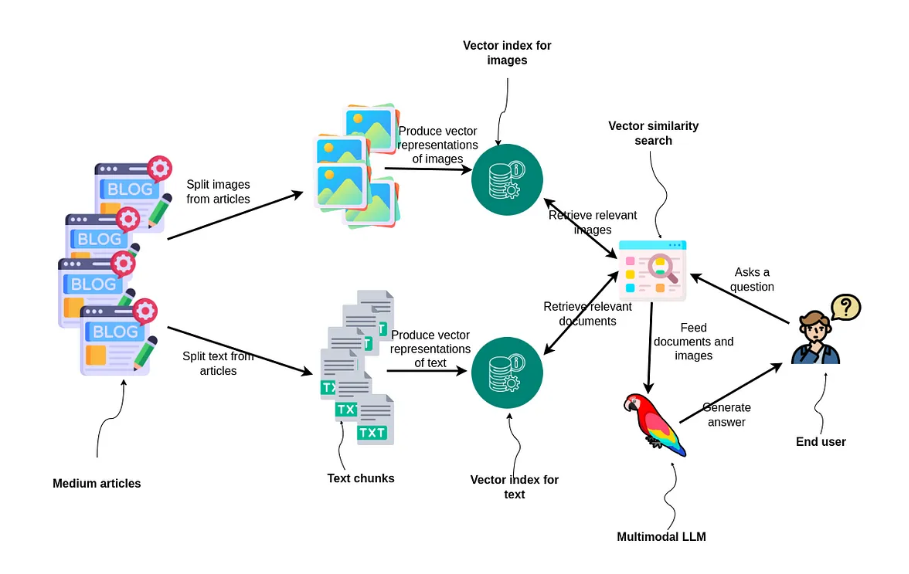


### Benefits
**1. Multi-modal Capability:** <br>Handles documents containing both text and visual elements, improving retrieval coverage.

**2. High Retrieval Precision:**<br> Embedding-based retrieval supports semantic search, even across paraphrased or reworded queries.

**3. Scalable & Flexible:**<br> The modular design allows easy scaling to large document corpora and can integrate alternative LLM models as needed.


# Implementation

### Installing Dependencies

In [ ]:
!pip install -q llama-index pillow pymupdf llama-index-llms-cohere llama-index-embeddings-cohere pdfplumber

In [2]:
import fitz  # PyMuPDF
from PIL import Image
import io
import os
from google.colab import userdata

import google.generativeai as genai
from IPython.display import Markdown, display, Image
from llama_index.core.node_parser import SentenceSplitter,SemanticSplitterNodeParser
from llama_index.embeddings.cohere import CohereEmbedding
from llama_index.core import VectorStoreIndex

import pdfplumber
from llama_index.core import Document



**Setting API keys as environment variables**

In [3]:
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
os.environ['COHERE_API_KEY'] = userdata.get('COHERE_API_KEY')

### Download the "Attention is all you need" paper

In [4]:
!wget https://arxiv.org/pdf/1706.03762
!mv 1706.03762 attention_is_all_you_need.pdf

--2025-06-20 09:38:50--  https://arxiv.org/pdf/1706.03762
Resolving arxiv.org (arxiv.org)... 151.101.195.42, 151.101.67.42, 151.101.3.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.195.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2215244 (2.1M) [application/pdf]
Saving to: ‘1706.03762’

1706.03762          100%[===================>]   2.11M  --.-KB/s    in 0.07s   

2025-06-20 09:38:51 (30.8 MB/s) - ‘1706.03762’ saved [2215244/2215244]



### Data Extraction

In [5]:
text_data = []
img_data = []

In [6]:
with fitz.open('attention_is_all_you_need.pdf') as pdf_file:
    # Create a directory to store the images
    if not os.path.exists("extracted_images"):
        os.makedirs("extracted_images")

    # Loop through every page in the PDF
    for page_number in range(len(pdf_file)):
        page = pdf_file[page_number]

        # Get the text on page
        text = page.get_text().strip()
        text_data.append({"response": text, "name": page_number+1})
        # Get the list of images on the page
        images = page.get_images(full=True)

        # Loop through all images found on the page
        for image_index, img in enumerate(images, start=0):
            xref = img[0]  # Get the XREF of the image
            base_image = pdf_file.extract_image(xref)  # Extract the image
            image_bytes = base_image["image"]  # Get the image bytes
            image_ext = base_image["ext"]  # Get the image extension

            # Load the image using PIL and save it
            image = Image.open(io.BytesIO(image_bytes))
            image.save(f"extracted_images/image_{page_number+1}_{image_index+1}.{image_ext}")

### Load model for Image Captioning

In [7]:
genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))
model = genai.GenerativeModel(model_name="gemini-1.5-flash")

### Image Captioning

Saving extracted images from the pdf

In [8]:
from PIL import Image
os.makedirs("extracted_images", exist_ok=True)

with pdfplumber.open("attention_is_all_you_need.pdf") as pdf:
    for i, page in enumerate(pdf.pages):
        for j, image in enumerate(page.images):
            cropped = page.crop((image['x0'], image['top'], image['x1'], image['bottom'])).to_image()

            # Access the actual PIL Image
            cropped_pil = cropped.original

            # Convert to RGB if needed
            if cropped_pil.mode == 'P':
                cropped_pil = cropped_pil.convert('RGB')

            filename = f"extracted_images/image_page_{i}_{j}.jpg"
            cropped_pil.save(filename, format="JPEG")


Captioning extracted images

In [9]:
img_data = []

for img in os.listdir("extracted_images"):
    image = Image.open(f"extracted_images/{img}")

    response = model.generate_content([
        image,
        "You are an assistant tasked with summarizing tables, images and text for retrieval. \
         These summaries will be embedded and used to retrieve the raw text or table elements. \
         Give a concise summary of the table or text that is well optimized for retrieval. Table or text or image:"
    ])

    #img_data.append({"response": response.text, "name": img})
    img_data.append({"response": response.text, "filename": f"extracted_images/{img}"})



### Vectorstore

In [10]:
# Convert text_data into Document list
docs_list = [Document(text=item['response'], metadata={"name": item['name']}) for item in text_data]

# Convert img_data into Document list
img_list = [Document(text=item['response'], metadata={"filename": item['filename']}) for item in img_data]

# Combine both
all_docs = docs_list + img_list

Loading Vectorstore and embedding using CohereEmbeddings

In [11]:
# Load VectorStoreIndex by selecting the splitter(chunk_size, chunk_overlap) and embedded model directly
embed_model = CohereEmbedding(
    api_key=os.environ["COHERE_API_KEY"],
    model_name="embed-english-v3.0"
)


node_parser = SemanticSplitterNodeParser(
    embed_model=embed_model,
    chunk_size=1024,  # token count
)

nodes = node_parser.get_nodes_from_documents(all_docs)

index = VectorStoreIndex(nodes, embed_model=embed_model)

In [12]:
base_retriever = index.as_retriever(similarity_top_k=5)
query = "What is the BLEU score of the Transformer (base model)?"
source_nodes = base_retriever.retrieve(query)

Viewing source nodes with their similarity score

In [13]:
# check source_nodes
from IPython.display import Markdown, display, Image
for node in source_nodes:
    print(f"---------------------------------------------")
    print(f"Score: {node.score:.3f}")
    display(Markdown(node.get_content()))
    image_filename = node.metadata.get("filename")
    if image_filename and os.path.exists(image_filename):
        display(Image(image_filename))
    else:
        print("No image file found.")

    print(f"---------------------------------------------\n\n")


---------------------------------------------
Score: 0.607


Table 2: The Transformer achieves better BLEU scores than previous state-of-the-art models on the
English-to-German and English-to-French newstest2014 tests at a fraction of the training cost.
Model
BLEU
Training Cost (FLOPs)
EN-DE
EN-FR
EN-DE
EN-FR
ByteNet [18]
23.75
Deep-Att + PosUnk [39]
39.2
1.0 · 1020
GNMT + RL [38]
24.6
39.92
2.3 · 1019
1.4 · 1020
ConvS2S [9]
25.16
40.46
9.6 · 1018
1.5 · 1020
MoE [32]
26.03
40.56
2.0 · 1019
1.2 · 1020
Deep-Att + PosUnk Ensemble [39]
40.4
8.0 · 1020
GNMT + RL Ensemble [38]
26.30
41.16
1.8 · 1020
1.1 · 1021
ConvS2S Ensemble [9]
26.36
41.29
7.7 · 1019
1.2 · 1021
Transformer (base model)
27.3
38.1
3.3 · 1018
Transformer (big)
28.4
41.8
2.3 · 1019
Residual Dropout
We apply dropout [33] to the output of each sub-layer, before it is added to the
sub-layer input and normalized. In addition, we apply dropout to the sums of the embeddings and the
positional encodings in both the encoder and decoder stacks. For the base model, we use a rate of
Pdrop = 0.1.
Label Smoothing
During training, we employed label smoothing of value ϵls = 0.1 [36]. This
hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.
6
Results
6.1
Machine Translation
On the WMT 2014 English-to-German translation task, the big transformer model (Transformer (big)
in Table 2) outperforms the best previously reported models (including ensembles) by more than 2.0
BLEU, establishing a new state-of-the-art BLEU score of 28.4. The configuration of this model is
listed in the bottom line of Table 3. 

No image file found.
---------------------------------------------


---------------------------------------------
Score: 0.514


Training took 3.5 days on 8 P100 GPUs. Even our base model
surpasses all previously published models and ensembles, at a fraction of the training cost of any of
the competitive models.
On the WMT 2014 English-to-French translation task, our big model achieves a BLEU score of 41.0,
outperforming all of the previously published single models, at less than 1/4 the training cost of the
previous state-of-the-art model. The Transformer (big) model trained for English-to-French used
dropout rate Pdrop = 0.1, instead of 0.3.
For the base models, we used a single model obtained by averaging the last 5 checkpoints, which
were written at 10-minute intervals. For the big models, we averaged the last 20 checkpoints. We
used beam search with a beam size of 4 and length penalty α = 0.6 [38]. These hyperparameters
were chosen after experimentation on the development set. We set the maximum output length during
inference to input length + 50, but terminate early when possible [38].
Table 2 summarizes our results and compares our translation quality and training costs to other model
architectures from the literature. We estimate the number of floating point operations used to train a
model by multiplying the training time, the number of GPUs used, and an estimate of the sustained
single-precision floating-point capacity of each GPU 5.
6.2
Model Variations
To evaluate the importance of different components of the Transformer, we varied our base model
in different ways, measuring the change in performance on English-to-German translation on the
5We used values of 2.8, 3.7, 6.0 and 9.5 TFLOPS for K80, K40, M40 and P100, respectively.
8

No image file found.
---------------------------------------------


---------------------------------------------
Score: 0.511


Provided proper attribution is provided, Google hereby grants permission to
reproduce the tables and figures in this paper solely for use in journalistic or
scholarly works.
Attention Is All You Need
Ashish Vaswani∗
Google Brain
avaswani@google.com
Noam Shazeer∗
Google Brain
noam@google.com
Niki Parmar∗
Google Research
nikip@google.com
Jakob Uszkoreit∗
Google Research
usz@google.com
Llion Jones∗
Google Research
llion@google.com
Aidan N. Gomez∗†
University of Toronto
aidan@cs.toronto.edu
Łukasz Kaiser∗
Google Brain
lukaszkaiser@google.com
Illia Polosukhin∗‡
illia.polosukhin@gmail.com
Abstract
The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks that include an encoder and a decoder. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convolutions
entirely. Experiments on two machine translation tasks show these models to
be superior in quality while being more parallelizable and requiring significantly
less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-
to-German translation task, improving over the existing best results, including
ensembles, by over 2 BLEU. On the WMT 2014 English-to-French translation task,
our model establishes a new single-model state-of-the-art BLEU score of 41.8 after
training for 3.5 days on eight GPUs, a small fraction of the training costs of the
best models from the literature. We show that the Transformer generalizes well to
other tasks by applying it successfully to English constituency parsing both with
large and limited training data.
∗Equal contribution. 

No image file found.
---------------------------------------------


---------------------------------------------
Score: 0.483


Table 3: Variations on the Transformer architecture. Unlisted values are identical to those of the base
model. All metrics are on the English-to-German translation development set, newstest2013. Listed
perplexities are per-wordpiece, according to our byte-pair encoding, and should not be compared to
per-word perplexities.
N
dmodel
dff
h
dk
dv
Pdrop
ϵls
train
PPL
BLEU
params
steps
(dev)
(dev)
×106
base
6
512
2048
8
64
64
0.1
0.1
100K
4.92
25.8
65
(A)
1
512
512
5.29
24.9
4
128
128
5.00
25.5
16
32
32
4.91
25.8
32
16
16
5.01
25.4
(B)
16
5.16
25.1
58
32
5.01
25.4
60
(C)
2
6.11
23.7
36
4
5.19
25.3
50
8
4.88
25.5
80
256
32
32
5.75
24.5
28
1024
128
128
4.66
26.0
168
1024
5.12
25.4
53
4096
4.75
26.2
90
(D)
0.0
5.77
24.6
0.2
4.95
25.5
0.0
4.67
25.3
0.2
5.47
25.7
(E)
positional embedding instead of sinusoids
4.92
25.7
big
6
1024
4096
16
0.3
300K
4.33
26.4
213
development set, newstest2013. We used beam search as described in the previous section, but no
checkpoint averaging. 

No image file found.
---------------------------------------------


---------------------------------------------
Score: 0.389


Table 4: The Transformer generalizes well to English constituency parsing (Results are on Section 23
of WSJ)
Parser
Training
WSJ 23 F1
Vinyals & Kaiser el al. (2014) [37]
WSJ only, discriminative
88.3
Petrov et al. (2006) [29]
WSJ only, discriminative
90.4
Zhu et al. (2013) [40]
WSJ only, discriminative
90.4
Dyer et al. (2016) [8]
WSJ only, discriminative
91.7
Transformer (4 layers)
WSJ only, discriminative
91.3
Zhu et al. (2013) [40]
semi-supervised
91.3
Huang & Harper (2009) [14]
semi-supervised
91.3
McClosky et al. (2006) [26]
semi-supervised
92.1
Vinyals & Kaiser el al. (2014) [37]
semi-supervised
92.1
Transformer (4 layers)
semi-supervised
92.7
Luong et al. (2015) [23]
multi-task
93.0
Dyer et al. (2016) [8]
generative
93.3
increased the maximum output length to input length + 300. We used a beam size of 21 and α = 0.3
for both WSJ only and the semi-supervised setting.
Our results in Table 4 show that despite the lack of task-specific tuning our model performs sur-
prisingly well, yielding better results than all previously reported models with the exception of the
Recurrent Neural Network Grammar [8].
In contrast to RNN sequence-to-sequence models [37], the Transformer outperforms the Berkeley-
Parser [29] even when training only on the WSJ training set of 40K sentences.
7
Conclusion
In this work, we presented the Transformer, the first sequence transduction model based entirely on
attention, replacing the recurrent layers most commonly used in encoder-decoder architectures with
multi-headed self-attention.
For translation tasks, the Transformer can be trained significantly faster than architectures based
on recurrent or convolutional layers. On both WMT 2014 English-to-German and WMT 2014
English-to-French translation tasks, we achieve a new state of the art. In the former task our best
model outperforms even all previously reported ensembles.


No image file found.
---------------------------------------------




### Query and Response

In [14]:
from llama_index.llms.cohere import Cohere
from llama_index.core.prompts import PromptTemplate

llm = Cohere(
    model="command-r",  # or command-r-plus if you have access
    temperature=0,
    api_key=os.environ["COHERE_API_KEY"],
    max_tokens=512,
)


# Build your prompt
prompt_template = """
You are an assistant for question-answering tasks. Answer the question based upon your knowledge.
Use three-to-five sentences maximum and keep the answer concise.

Context:
{context_str}

Question:
{query_str}
"""
# Convert string into a LlamaIndex PromptTemplate object
custom_prompt = PromptTemplate(template=prompt_template)


query_engine = index.as_query_engine(
  streaming=True,
  similarity_top_k=2,
  llm=llm,
  text_qa_template=custom_prompt
)


In [15]:
query="What is the BLEU score of the Transformer (base model)?"
response = query_engine.query("What is the transformer architecture?")
display(Markdown(f"<b>{response}</b>"))

<b>The Transformer is a model architecture that relies entirely on attention mechanisms to capture global dependencies between input and output sequences, doing away with recurrence entirely. It's comprised of stacked self-attention layers, allowing for increased parallelization and efficient processing. This architecture has proven effective for sequence modeling tasks, achieving state-of-the-art results in translation quality. The encoder has N=6 layers, each with two sub-layers, and the decoder also employs stacked self-attention layers.</b>

### Extra examples

In [16]:
queries=["What BLEU score did the Transformer achieve on WMT 2014 English-to-German?",
         "Show me the diagram of the Transformer architecture.",
         "What is positional encoding in Transformer?",
         "Explain the architecture of Transformer",
         "How many layers does the encoder have?"]

<b>Question</b>:<br>What BLEU score did the Transformer achieve on WMT 2014 English-to-German?<br><br><b> Answer: </b><br>The Transformer model achieved a BLEU score of 28.4 on the WMT 2014 English-to-German translation task.

<b>Question</b>:<br>Show me the diagram of the Transformer architecture.<br><br><b> Answer: </b><br>Here is the diagram of the Transformer architecture:

![Transformer Architecture](extracted_images/image_3_1.png)

It consists of stacked layers, with various sub-layers and modules, like multi-head attention and feed-forward networks, processing the data flow.

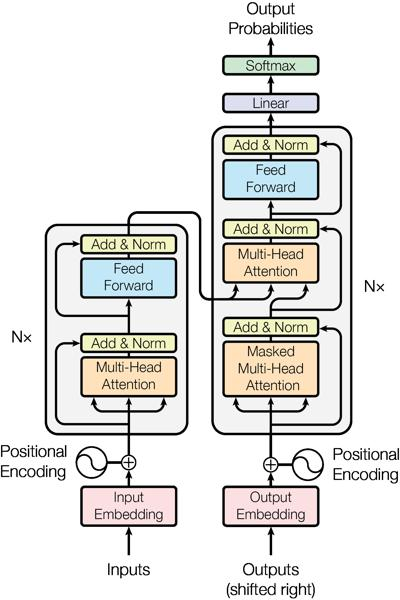

<b>Question</b>:<br>What is positional encoding in Transformer?<br><br><b> Answer: </b><br>Positional Encoding in Transformers adds information about the relative positions of tokens in a sequence to the input embeddings. This is essential as Transformers lack recurrence or convolution, which would otherwise provide positional awareness. It's a way to indicate the order of tokens and is implemented using learned or fixed functions. Sine and cosine functions are often used for this purpose, applied to the position of the token.

<b>Question</b>:<br>Explain the architecture of Transformer<br><br><b> Answer: </b><br>The Transformer model has a stacked architecture, comprising an encoder and decoder. Each encoder layer has two sub-layers, and the decoder also follows a similar structure. The model uses self-attention mechanisms to draw global dependencies between input and output, removing the need for recurrence and enabling more parallelization. This approach improves translation quality and reduces computational requirements.

<b>Question</b>:<br>How many layers does the encoder have?<br><br><b> Answer: </b><br>The encoder consists of N = 6 layers, each comprising two sub-layers.

In [19]:
from PIL import Image as PILImage

for query in queries:
  response = query_engine.query(query)
  display(Markdown(f"<b>Question</b>:<br>{query}<br><br><b> Answer: </b><br>{response}"))
  # Display images from source nodes if available
  for node in response.source_nodes:
      filename = node.metadata.get("filename")
      if filename and os.path.exists(filename):
        img = PILImage.open(filename) # Use the aliased PIL.Image
        img_resized = img.resize((400, 600))  # width x height in pixels
        buffer = io.BytesIO()
        img_resized.save(buffer, format="JPEG")
        display(Image(data=buffer.getvalue())) # IPython.display.Image is used here